In [1]:
# %pip install python-mnist
# %pip install matplotlib

import os
import math
import random
from mnist import MNIST
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle
import time

%matplotlib inline

### Data preparation

In [2]:
mndata = MNIST('dataset')

x_train, y_train = mndata.load_training()

### Analysis

In [3]:
overlayed = {i: [0] * 784 for i in range(10)}

for image, cls_ in zip(x_train, y_train):
    for idx, color in enumerate(image):        
        overlayed[cls_][idx] += (color/255)

# overlayed

In [6]:
def flatten(array):
    flat = []

    for item in array:
        try:
            iter(item)
            flat.extend(flatten(item))
        except:
            flat.append(item)

    return flat

def reshape(array, rows, cols):
    flat_array = flatten(array)

    if rows * cols != len(flat_array):
        raise Exception(f"Can't reshape array to ({rows}, {cols})")

    reshaped = [[0] * cols for _ in range(rows)]    

    for row in range(rows):
        for col in range(cols):
            reshaped[row][col] = flat_array[row * cols + col]

    return reshaped


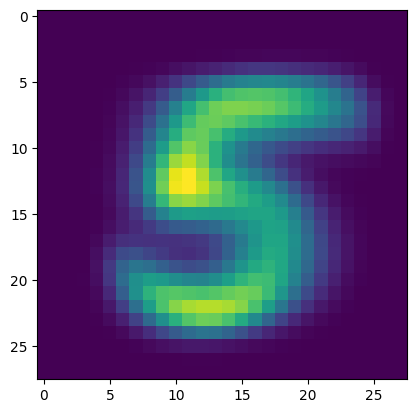

In [24]:
plt.imshow(reshape(overlayed[5], 28, 28))

In [8]:
def prepare(image):
    image = reshape(image, 28, 28)

    output = []
    
    # major diagonal
    for i in range(28):
        output.append(image[i][i] / 255)
    
    # minor diagonal
    for i in range(28):
        output.append(image[27 - i][i] / 255)
    
    # center horizontal ( 3 pixels)
    for j in range(13, 16):
        for i in range(28):        
            output.append(image[j][i] / 255)

    # center vertical    ( 3 pixels) 
    for j in range(13, 16):
        for i in range(28):        
            output.append(image[i][j] / 255)
    
    # bias
    output.append(1)


    return output    

In [9]:
# Normalize input
x_train_normalized = []

for image in x_train:
    x_train_normalized.append(prepare(image))

### Logistic Regression

In [10]:
def sigmoid_scalar(x):
    # to avoid overflow
    if x < 0:
        sigmoid = math.exp(x) / (1 + math.exp(x))
    else:
        sigmoid = 1 / (1 + math.exp(-x))

    # to handle machine precision errors
    sigmoid = max(0.0001, sigmoid)
    sigmoid = min(0.9999, sigmoid)

    return sigmoid

In [11]:
def argmax(values):
    max_value = float('-inf')
    max_index = 0

    for idx, value in enumerate(values):
        if value > max_value:
            max_index = idx
            max_value = value

    return max_index


In [12]:
def predict(sample_x, weights):
    # calculate z = sum(w * x + b)
    # here bias (b) is also included in weights
    z = 0
    for x, w in zip(sample_x, weights):
        z += w * x

    # sigmoid(z)
    return sigmoid_scalar(z)

In [13]:
def cross_entropy_loss(predicted_value, actual_value):
    y = actual_value
    y_pred = predicted_value    

    if y == 1:        
        return -math.log(y_pred)

    else:        
        return -math.log(1 - y_pred)

In [14]:
def gradient_decent(X, label, weights=None, learning_rate=0.1):
    n_features = len(X[0])

    # initialize weight with random values (equal length to x's features)
    if weights == None:
        weights = [random.random() for _ in range(n_features)]

    loss = 0

    for x, y in zip(X, label):
        y_pred = predict(x, weights)
        loss += cross_entropy_loss(y_pred, y)

        # dw = (y_pred - y) * x
        # weight = weight - learning_rate * dw
        err = y_pred - y
        for i in range(n_features):
            dw_i = err * x[i]
            weights[i] -= learning_rate * dw_i

    return weights, loss / len(X)

In [15]:
def train_binary_class(x_train, y_train, learning_rate, epoch, verbose=False):
    weights = None

    # for graphing
    history = []

    for i in range(epoch):
        weights, loss = gradient_decent(x_train, y_train, weights, learning_rate)

        history.append(loss)

        if verbose:
            print(f"Epoch [{i}]\n\t- Cross entropy loss: {loss}\n")

    return weights, history

In [16]:
def train_multiclass(x_train, y_train, learning_rate, epoch, verbose=False):
    # identify unique classes
    classes = range(0, 10)

    # for each class create separate labels suitable for binary classification
    labels = [[] for _ in classes]

    for class_ in classes:
        for label in y_train:            
            if label == class_:
                labels[class_].append(1)

            else:
                labels[class_].append(0)
    
    # now that we have separate labels for each class
    # lets train binary classifier for each class
    # (each classifier will identify whether sample x is member of class or not)

    # we have 10 classes so we need 10 binary classifiers
    classifiers = [None] * 10
    histories = [None] * 10

    for cls_, label in enumerate(labels):
        if verbose:
            print(f'Training class [{cls_}]')

        weights, history = train_binary_class(x_train, label, learning_rate, epoch)        

        classifiers[cls_] = weights
        histories[cls_] = history

        if verbose:
            print('---------------------------------------------------------------------')
    

    return classifiers, histories

In [17]:
def predict_class(sample_x, model):
    class_probabilities = []
    
    for weights in model:
        class_probability = predict(sample_x, weights)
        class_probabilities.append(class_probability)
    
    return argmax(class_probabilities)

In [18]:
# sum([predict_class(x_train_normalized[i], model) == y_train[i] for i in range(60000)])

def confusion_matrix(test_x, label, model):    

    grid = [[0] * 10 for _ in range(10)]
    
    net_accuracy = 0    

    for i in range(len(test_x)):
        prediction = predict_class(test_x[i], model)
                
        actual = label[i]

        grid[prediction][actual] += 1

        if prediction == label[i]:
            net_accuracy += 1              

    return grid, net_accuracy / len(test_x)


### Training

In [22]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5]

epochs = 10

train_size = 50000

x_train_set = x_train_normalized[:train_size]
y_train_set = y_train[:train_size]

x_validation_set = x_train_normalized[train_size:]
y_validaiton_set = y_train[train_size:]


histories = []

for eta in learning_rates:
    print(f'Learning rate: {eta}')

    start_time = time.perf_counter()

    model, history = train_multiclass(x_train_set, y_train_set, eta, epochs, verbose=True)

    time_taken = time.perf_counter() - start_time  

    with open(f'learning_rate_[{eta}].m', 'wb') as f:
        pickle.dump(model, f)

    histories.append(
      (   time_taken,
          history,
          *confusion_matrix(x_validation_set, y_validaiton_set, model)
      )
    )

Learning rate: 0.0001
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Training class [3]
---------------------------------------------------------------------
Training class [4]
---------------------------------------------------------------------
Training class [5]
---------------------------------------------------------------------
Training class [6]
---------------------------------------------------------------------
Training class [7]
---------------------------------------------------------------------
Training class [8]
---------------------------------------------------------------------
Training class [9]
---------------------------------------------------------------------


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Learning rate: 0.001
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Training class [3]
---------------------------------------------------------------------
Training class [4]
---------------------------------------------------------------------
Training class [5]
---------------------------------------------------------------------
Training class [6]
---------------------------------------------------------------------
Training class [7]
---------------------------------------------------------------------
Training class [8]
---------------------------------------------------------------------
Training class [9]
---------------------------------------------------------------------


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Learning rate: 0.01
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Training class [3]
---------------------------------------------------------------------
Training class [4]
---------------------------------------------------------------------
Training class [5]
---------------------------------------------------------------------
Training class [6]
---------------------------------------------------------------------
Training class [7]
---------------------------------------------------------------------
Training class [8]
---------------------------------------------------------------------
Training class [9]
---------------------------------------------------------------------


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Learning rate: 0.1
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Training class [3]
---------------------------------------------------------------------
Training class [4]
---------------------------------------------------------------------
Training class [5]
---------------------------------------------------------------------
Training class [6]
---------------------------------------------------------------------
Training class [7]
---------------------------------------------------------------------
Training class [8]
---------------------------------------------------------------------
Training class [9]
---------------------------------------------------------------------


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Learning rate: 1.0
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Training class [3]
---------------------------------------------------------------------
Training class [4]
---------------------------------------------------------------------
Training class [5]
---------------------------------------------------------------------
Training class [6]
---------------------------------------------------------------------
Training class [7]
---------------------------------------------------------------------
Training class [8]
---------------------------------------------------------------------
Training class [9]
---------------------------------------------------------------------


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Learning rate: 1.5
Training class [0]
---------------------------------------------------------------------
Training class [1]
---------------------------------------------------------------------
Training class [2]
---------------------------------------------------------------------
Training class [3]
---------------------------------------------------------------------
Training class [4]
---------------------------------------------------------------------
Training class [5]
---------------------------------------------------------------------
Training class [6]
---------------------------------------------------------------------
Training class [7]
---------------------------------------------------------------------
Training class [8]
---------------------------------------------------------------------
Training class [9]
---------------------------------------------------------------------


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
x_test, y_test = mndata.load_testing()

x_test_normalized = []

for image in x_test:          
    x_test_normalized.append(prepare(image))

In [43]:
with open('learning_rate_[0.001].m', 'rb') as f:
    model = pickle.load(f)

matrix, accuracy = confusion_matrix(x_test_normalized, y_test, model)

(<matplotlib.image.AxesImage at 0x1dd1252beb0>, 0.8198)

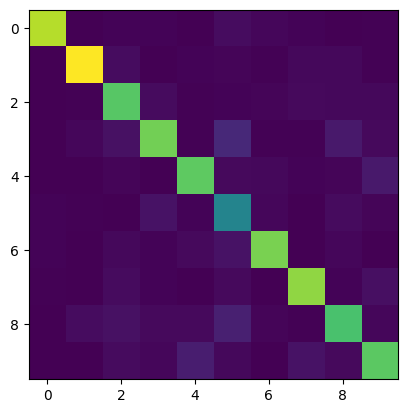

In [42]:
plt.imshow(matrix), accuracy